# How to remove motion noise from K2 data using the `SFFCorrector`?

You can use `lightkurve` to remove the spacecraft motion noise from K2 data. Targets in K2 data move over multiple pixels during the exposure due to thruster firings. This can be corrected using the Self Flat Fielding method (SFF), which you can read more about [here](https://docs.lightkurve.org/tutorials/04-replicate-vanderburg-2014-k2sff).

This tutorial demonstrates how you can apply the method on your light curves Using `lightkurve`.

Let's start by downloading a K2 light curve of an exoplanet host star.

In [1]:
from lightkurve import search_lightcurvefile
lcf = search_lightcurvefile('EPIC 247887989').download()  # returns a KeplerLightCurveFile
lc = lcf.PDCSAP_FLUX                                      # returns a KeplerLightCurve

# Remove nans and outliers
lc = lc.remove_nans().remove_outliers()              

# Remove long term trends
lc = lc.flatten(window_length=401)

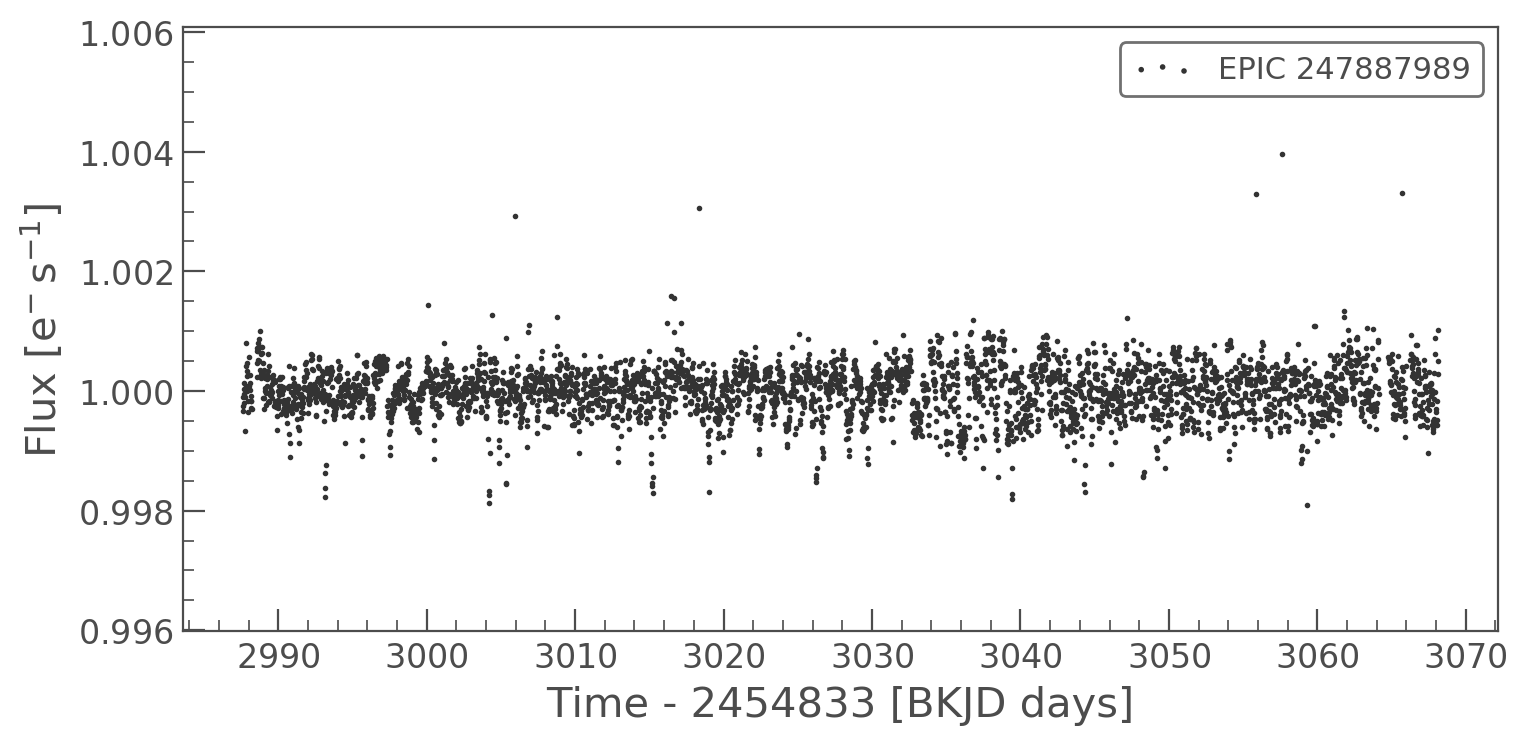

In [2]:
lc.scatter();

This light curve of the object [K2-133](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=K2-133+b&type=CONFIRMED_PLANET), which is known to host an exoplanet with a period of 3.0712 days.  The light curve shows a lot of motion noise on K2's typical 6-hour motion timescale.

Let's plot the folded version of it to see what the signal of the known transiting exoplanet looks like.

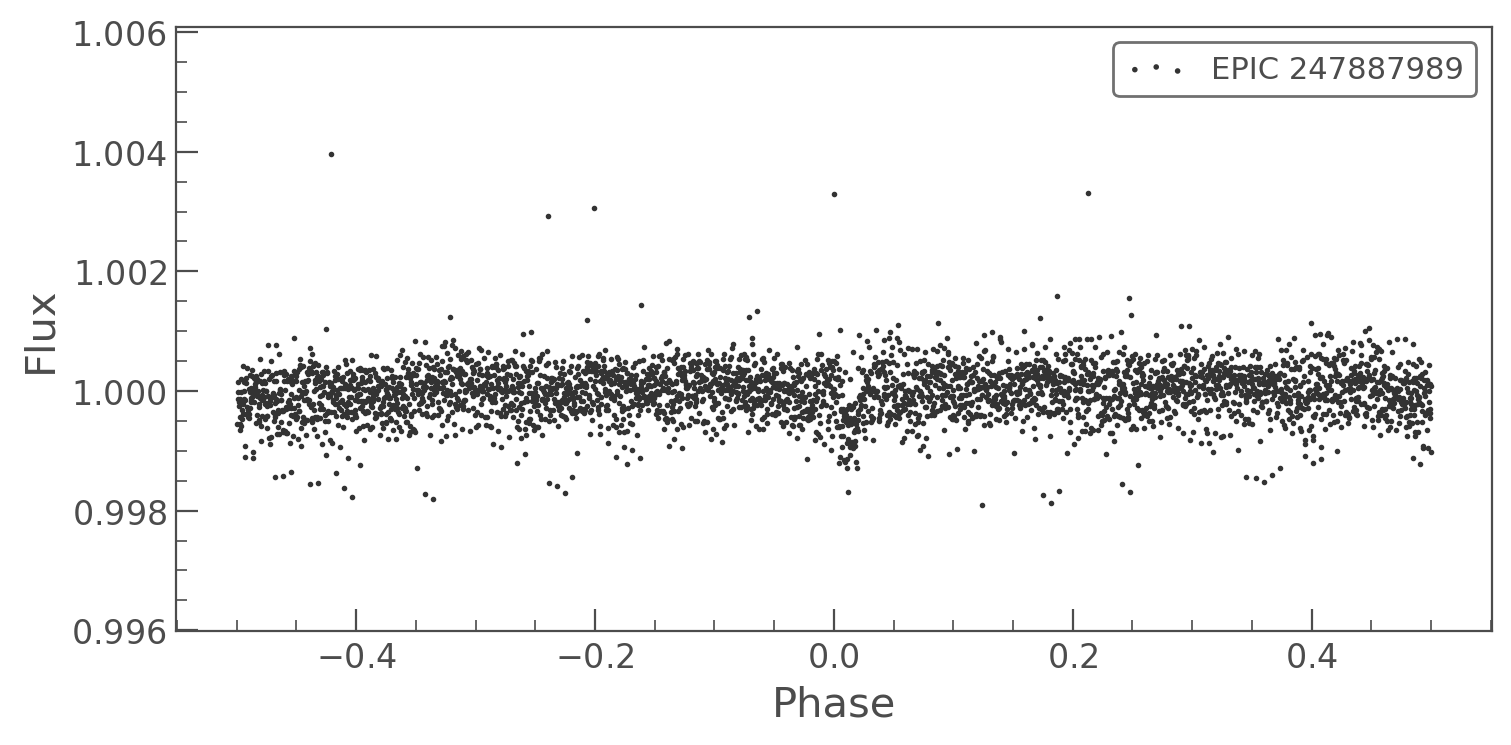

In [3]:
lc.fold(period=3.0712).scatter();

We can see the hint of an exoplanet transit close to the center, but the motion of the spacecraft has made it difficult to make out above the noise.

We can use the `SFFCorrector` class to remove this motion. An in-depth look into how the algorithm works can be found [here](https://docs.lightkurve.org/tutorials/04-replicate-vanderburg-2014-k2sff.html). You can tune the algorithm using a number of optional keywords, including:

* `degree` : *int*
        The degree of polynomials in the splines in time and arclength. 
* `niters` : *int*
        Number of iterations
* `bins` : *int*
        Number of bins to be used to create the piece-wise interpolation of arclength vs flux correction.
* `windows` : *int*
        Number of windows to subdivide the data.  The SFF algorithm is run independently in each window.

This [tutorial](https://docs.lightkurve.org/tutorials/04-replicate-vanderburg-2014-lightkurve.html) will teach you more about how to tune these parameters. For this problem, we will use the defaults, but increase the number of windows to 20.

In [4]:
corr_lc = lc.to_corrector("sff").correct(windows=20)

Note: this is identical to the following command:

In [5]:
from lightkurve import SFFCorrector
corr_lc = SFFCorrector(lc).correct(windows=20)

Now when we compare the two light curves we can see the clear signal from the exoplanet.

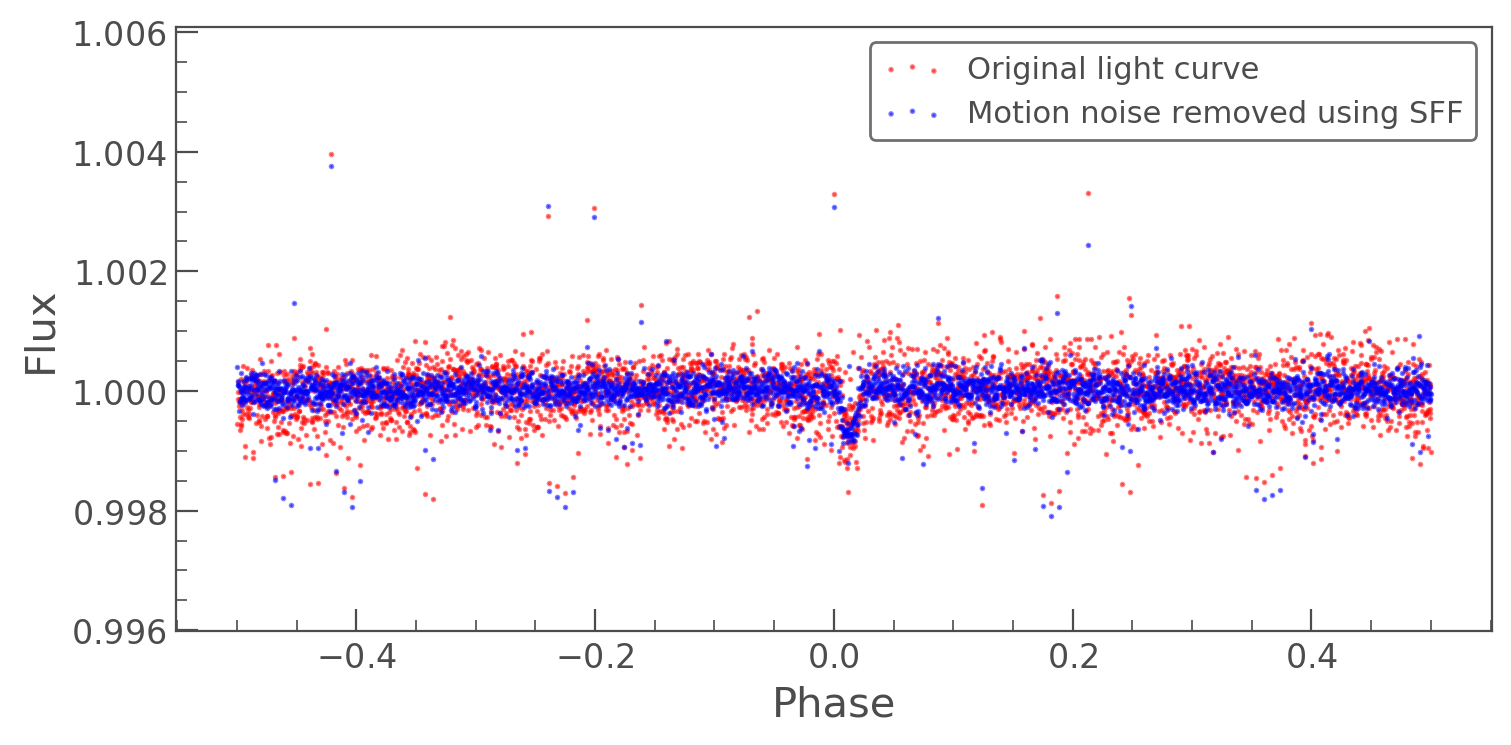

In [6]:
ax = lc.fold(period=3.0712).scatter(color='red', alpha=0.5, label='Original light curve')
ax = corr_lc.fold(period=3.0712).scatter(ax=ax, color='blue', alpha=0.5, label='Motion noise removed using SFF');

Voilà!  Correcting motion systematics can vastly improve the signal-to-noise ratio in your lightcurve.